<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="680" height="140" align="right"/>


<center><h1> Machine Learning 203008067 </header1></center>
<left><h1> Componente práctico </header1></left>

Presentado por: Oscar Andrés Russi Porras  <br>
Fecha: 18/04/2024

## Importación de librerias necesarias

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import datetime

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz

## Cargar el Dataset

In [271]:
#cargamos del archivo ubicado en la siguiente ubicacióm
url = 'https://drive.google.com/uc?id=1Ck6St_z7q3jPoJ7SbUC8ulCCQE7nOFKg'
df = pd.read_csv(url) # leer el csv
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df.sample(5)

,date,day,quarter,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,actual_productivity,no_of_workers
231,1/13/2015,3,Quarter2,finishing,7,0.8,2.90,0.0,1440,0,0.0,0,0,0.670076,24
219,1/13/2015,3,Quarter2,finishing,9,0.8,3.94,0.0,1440,0,0.0,0,0,0.858144,32
284,1/17/2015,7,Quarter3,sweing,7,0.8,25.90,1396.0,10170,50,0.0,0,0,0.800129,32
713,02/11/2015,4,Quarter2,sweing,8,0.6,30.10,1069.0,4560,30,0.0,0,1,0.714410,29
875,2/22/2015,1,Quarter4,finishing,12,0.8,5.13,0.0,1080,0,0.0,0,0,0.902500,32


# Tranformación y limpieza de datos

In [272]:
# Contar los valores nulos en cada columna
nulos_por_columna = df.isnull().sum()
print(nulos_por_columna)

date                     0
day                      0
quarter                  0
department               0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
actual_productivity      0
no_of_workers            0
dtype: int64


In [273]:
# contar campos vacíos
campos_vacios = df.eq('').sum()
print(campos_vacios)

date                     0
day                      0
quarter                  0
department               0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
actual_productivity      0
no_of_workers            0
dtype: int64


In [274]:
non_float_columns = list(df.select_dtypes(exclude=['float64']).columns)
non_float_columns # valores que no son float

['date',
 'day',
 'quarter',
 'department',
 'team',
 'over_time',
 'incentive',
 'idle_men',
 'no_of_style_change',
 'no_of_workers']

In [275]:
# miramos los valores distintos en cada columna que no sea float
for col in ["no_of_workers","over_time"]:
  uniques= [f"'{str(val)}'" for val in list(df[col].unique())]
  print(f"{col}: {','.join(uniques)}")

no_of_workers: '32','29','24','26','20','15','14','31','40'
over_time: '7080','960','3660','1920','6720','6900','6000','6480','2160','7200','1440','6600','5640','1560','6300','6540','13800','6975','7020','6780','4260','6660','4320','6960','2400','3840','4800','4440','1800','2700','10620','10350','9900','5310','10170','4470','10530','10440','5490','5670','9720','12600','10050','15120','14640','900','10260','2760','4710','9540','7680','3600','6420','7980','3240','8220','6930','8460','7350','5400','1620','1980','2970','7320','5100','3390','1260','3420','8970','4950','10080','9810','6570','5040','4380','3630','8280','6120','5580','3720','5760','7470','10500','6360','4140','8400','12180','9000','15000','10770','12000','9360','3060','2520','720','3780','10320','360','6840','1080','1200','4080','240','5880','6240','4200','3960','600','2280','1320','5460','2040','4020','3000','3360','5820','6060','2640','7500','2880','120','3300','0','3480','7380','4560','5940','7140','5160','5280','840','5520

In [276]:
print(df['date'].max())
print(df['date'].min())

2/28/2015
01/01/2015


In [277]:
# Fecha base (Epoch Unix)
epoch = datetime.datetime(2015, 1, 1)
df['date'] = df['date'].apply(lambda d: int((pd.to_datetime(d) - epoch).total_seconds())/86400)
df['date'] = pd.to_numeric(df['date'], errors='coerce').astype('Int64')
df['date']

0        0
1        0
2        0
3        0
4        0
        ..
1171    68
1172    68
1173    69
1174    69
1175    69
Name: date, Length: 1176, dtype: Int64

In [278]:
# Elimino el espacio adicional que tiene el campo "department" en algunos registros con valor "finishing"
df['department'].replace(to_replace='finishing ', value = 'finishing', inplace=True)
df['department'].unique()

array(['sweing', 'finishing'], dtype=object)

In [279]:
# función para codificar columnas
def generate_coded_column(column, df_):
  list_values = list(df_[column].unique())
  for i in range(len(list_values)):
    df_[column].replace(to_replace=list_values[i], value = i, inplace=True)
  return df_

df=generate_coded_column("department", df) # codificar department
df=generate_coded_column("quarter", df) # codificar quarter
df.sample(5)

,date,day,quarter,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,actual_productivity,no_of_workers
156,9,7,1,1,2,0.80,3.94,0.0,1440,0,0.0,0,0,0.817102,32
518,30,7,4,0,2,0.80,22.52,1397.0,6840,113,0.0,0,0,1.000230,31
607,34,4,0,0,4,0.35,30.10,287.0,6060,23,150.0,15,0,0.350706,15
197,11,2,1,0,1,0.80,26.16,1099.0,8220,75,0.0,0,0,0.850522,32
804,47,3,2,1,4,0.75,5.13,0.0,960,0,0.0,0,0,0.656667,24


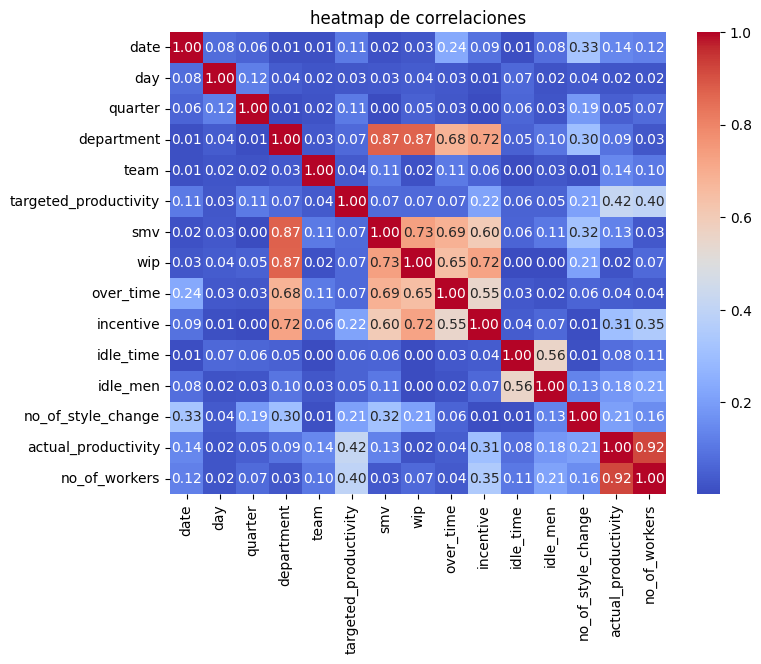

In [280]:
# mostrar correlaciones entre las variables numéricas
correlation_matrix = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix.abs(),annot=True,cmap='coolwarm',fmt='.2f')
plt.title('heatmap de correlaciones')
plt.show()

In [281]:
df_original= df.copy()
df_original.sample(5)

,date,day,quarter,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,actual_productivity,no_of_workers
247,13,4,1,0,12,0.80,11.61,1159.0,2970,50,0.0,0,0,0.800313,32
1165,68,3,1,0,1,0.75,26.82,1322.0,7080,45,0.0,0,0,0.750051,29
366,20,4,2,0,9,0.80,54.56,757.0,4140,29,0.0,0,0,0.520238,26
871,52,1,3,0,5,0.80,30.10,450.0,5700,0,4.5,25,0,0.307501,15
150,9,7,1,1,9,0.80,3.94,0.0,1440,0,0.0,0,0,0.858144,32


# Acción 1: Aplicación modelos lineales.

## a.Seleccionar una base de entrenamiento (80%) y una base de prueba (20%).

In [282]:
df=df[["no_of_workers","over_time","actual_productivity"]]
df_modelo_lineal = df.copy()
df_modelo_lineal.sample(5)

,no_of_workers,over_time,actual_productivity
199,32,10170,0.850137
416,32,1440,0.970076
822,29,960,0.734646
1145,29,4560,0.700246
1096,32,1080,0.945556


In [283]:
def generate_minmax_scaled(df_):
  scaler=MinMaxScaler()
  df_scaled =  scaler.fit_transform(df_)
  df_scaled = pd.DataFrame(df_scaled)
  # Se importan los nombres de las columnas
  df_scaled.columns = df_.columns
  return df_scaled

def generate_standard_scaled(df_, dependant):
  scaler=StandardScaler()
  cols = [col for col in df_.columns if col!=dependant]
  for col in cols:
    df_[col] = scaler.fit_transform(df_[[col]])
  return df_

df_modelo_lineal= generate_standard_scaled(df_modelo_lineal, "actual_productivity")
df_modelo_lineal.sample(5)

,no_of_workers,over_time,actual_productivity
839,0.159137,-0.188904,0.750651
513,-0.845936,-0.079325,0.600598
748,0.159137,0.176361,0.700206
1070,0.159137,0.724259,0.700424
164,-0.845936,1.509579,0.673245


In [284]:
# función para dividir los datos para el training y el testing
def split_data(dependant, df_): # dividir en 20% datos para testing y 80% para training, semilla 42
  X = df_[[col for col in  df_.columns if col!=dependant]]  # variables independientes
  y = df_[dependant]  # Variable dependiente
  try:
        # Intenta dividir los datos con estratificación cuando sea posibe
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  except ValueError as e:
        # Si hay un error, probablemente debido a la estratificación, hacerlo sin estratificar
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data('actual_productivity',df_modelo_lineal)

print(f"dimensiones de X_train: {X_train.shape}")
print(f"dimensiones de X_test: {X_test.shape}")
print(f"dimensiones de y_train: {y_train.shape}")
print(f"dimensiones de y_test: {y_test.shape}")


dimensiones de X_train: (940, 2)
dimensiones de X_test: (236, 2)
dimensiones de y_train: (940,)
dimensiones de y_test: (236,)


## b. Con la base de entrenamiento aplicar un modelo de regresión lineal para predecir la productividad real a partir del número de trabajadores de cada equipo y el tiempo extra en minutos.

In [285]:
def generar_modelo_lineal(X_train_, X_test_, y_train_, y_test_):
  # Paso 3: Aplicar el modelo de regresión lineal
  modelo = LinearRegression()
  modelo.fit(X_train_, y_train_)
  # Paso 5: Visualizar los resultados con un diagrama de dispersión
  return modelo

modelo = generar_modelo_lineal(X_train, X_test, y_train, y_test)
print(modelo.coef_) #  cambio en las variables dependientes por una unidad de cambio en la variable independiente
print(modelo.intercept_) # valor de la variable dependiente cuando todas las variables independientes son iguales a 0

[ 0.16135178 -0.01287038]
0.7337984376210129


## c. Realizar las predicciones sobre la base de prueba.

In [286]:
# Paso 4: Realizar predicciones sobre el conjunto de prueba
y_predictions = modelo.predict(X_test)
#  mostrar datos
def get_stats(val,val_predict):
  r2=r2_score(val,val_predict)
  mse=metrics.mean_squared_error(val,val_predict)
  rmse=np.sqrt(mse)
  mae=metrics.mean_absolute_error(val,val_predict)
  correlacion, _ = pearsonr(val_predict,val)
  print("R2  :", np.round(r2,3)) # R^2, 1 si predice perfectamente la variable independiente, 0 si no predice mejor que simplemente tomar la media de los datos
  print("MSE  :", np.round(mse,3)) # Cuanto más bajo es el MSE, mejor es el modelo en términos de precisión. Un MSE de 0 significa que el modelo predice los valores exactos sin error.
  print("RMSE :", np.round(rmse,3)) # raiz cuadrada de MSE
  print("MAE :",np.round(mae,3)) # Proporciona una idea de cuán grande es el error de las predicciones, sin considerar su dirección
  print("Correlación :",np.round(correlacion,3)) # Un valor de 1 significa una correlación positiva perfecta entre las predicciones y los valores reales (a medida que uno aumenta, el otro también). Un valor de -1 indica una correlación negativa perfecta (a medida que uno aumenta, el otro disminuye). Un valor cercano a 0 indica que no hay correlación lineal entre las predicciones y los valores reales.
get_stats(y_test, y_predictions)

R2  : 0.844
MSE  : 0.004
RMSE : 0.067
MAE : 0.052
Correlación : 0.919


## d. Con los resultados del ítem anterior, realizar un diagrama de dispersión, en el eje X ubicar los valores predichos y en el eje Y ubicar los valores de productividad real.

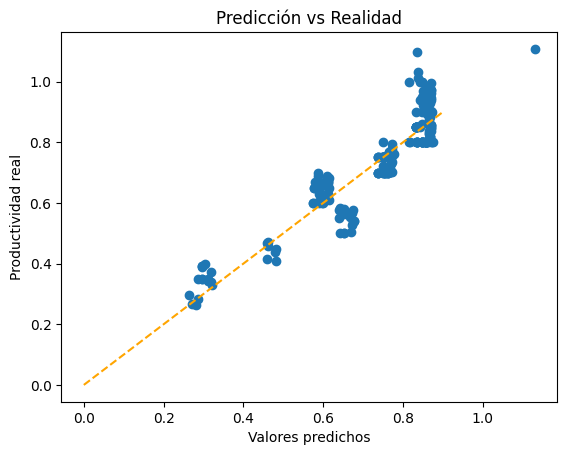

In [287]:
plt.scatter(y_predictions, y_test)
plt.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1), color='orange', linestyle='--', label='y = x')
plt.xlabel('Valores predichos')
plt.ylabel('Productividad real')
plt.title('Predicción vs Realidad')
plt.show()

# Acción 2: Aplicación modelo logístico.

## a. Construir la variable ‘nivel_productividad’ con niveles alto y bajo. Considere nivel alto a productividad real > 0.7 y nivel bajo a productividad real <=0.7

In [288]:
df_modelo_logistico= df.copy()

def add_nivel_productividad(df_): # crear variable "nivel_productividad"
  # "bajo" si actual_productivity es menor o igual a 0.7, de lo contrario "alto"
  df_['nivel_productividad']= df_['actual_productivity'].apply(lambda val: 'bajo' if val<=0.7 else 'alto')
  df_=df_.drop('actual_productivity', axis=1) # eliminar "actual_productivity" después de crear nivel_productividad
  df_['nivel_productividad'].value_counts()
  return df_

df_modelo_logistico=add_nivel_productividad(df_modelo_logistico)
df_modelo_logistico['nivel_productividad'].value_counts()

nivel_productividad
alto    814
bajo    362
Name: count, dtype: int64

## b. Con la base de entrenamiento aplicar un modelo de regresión logística para predecir el ‘nivel_productividad’ basado en el número de trabajadores de cada equipo y el tiempo extra en minutos.

In [289]:
# función para codificar columnas
def generate_coded_column(column, df_):
  list_values = list(df_[column].unique())
  for i in range(len(list_values)):
    df_[column].replace(to_replace=list_values[i], value = i, inplace=True)
  return df_

df_modelo_logistico= generate_coded_column('nivel_productividad',df_modelo_logistico) # codificamos la variable "nivel_productividad"
df_modelo_logistico['nivel_productividad'].sample(5)

140     0
1075    1
888     1
587     1
839     0
Name: nivel_productividad, dtype: int64

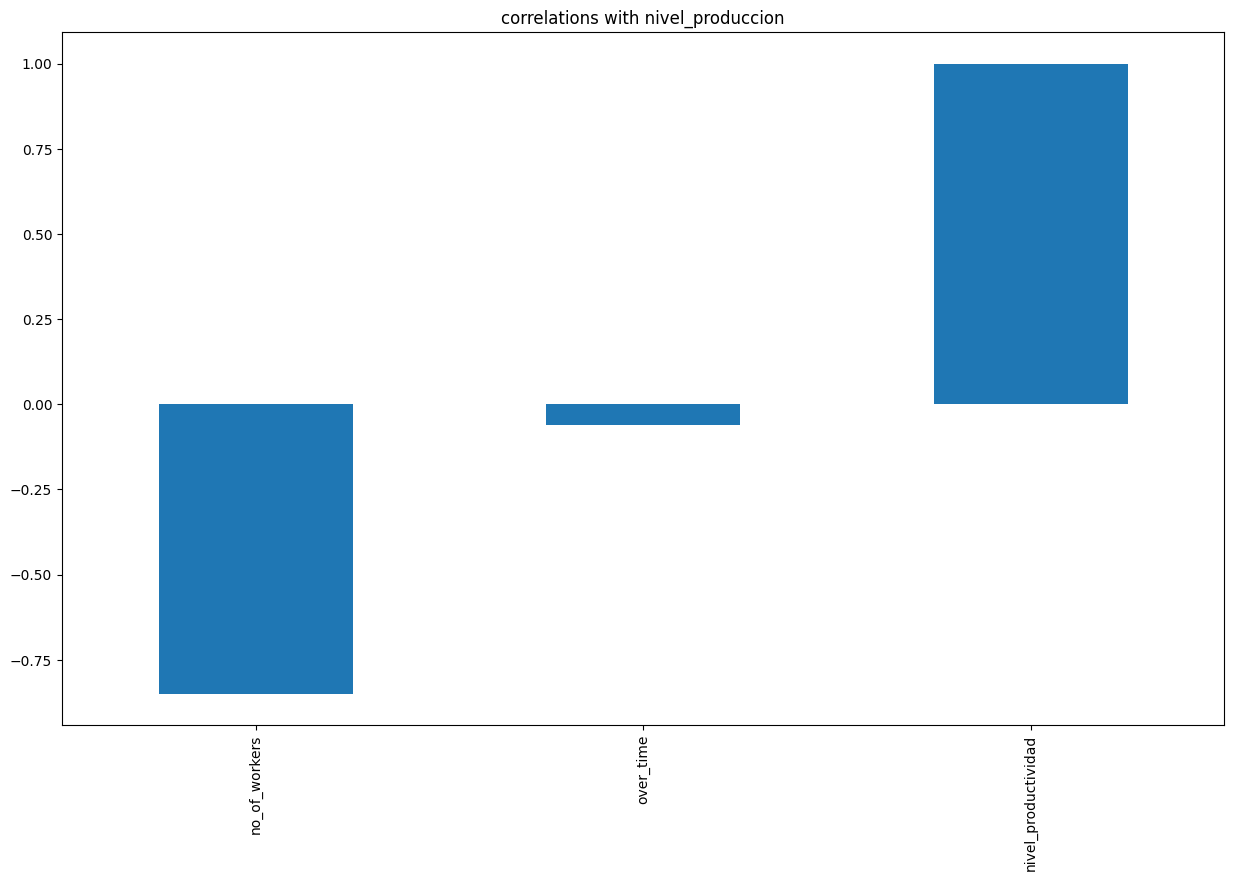

In [290]:
fig = plt.figure(figsize=(15,9))
df_modelo_logistico.corr()['nivel_productividad'].sort_values(ascending=True).plot(kind='bar',title="correlations with nivel_produccion")
plt.show() # mostrar en orden las variables más correlacionadas con nivel de productividad

In [291]:


df_minmax_logistico=generate_minmax_scaled(df_modelo_logistico.copy())
df_minmax_logistico.sample(5)

,no_of_workers,over_time,nivel_productividad
1129,0.692308,0.071429,0.0
56,0.384615,0.456349,1.0
900,0.576923,0.222222,0.0
383,0.384615,0.992063,1.0
962,0.576923,0.412698,0.0


In [292]:
df_standard_logistico=generate_standard_scaled(df_modelo_logistico.copy(),"nivel_productividad")
df_standard_logistico.sample(5)

,no_of_workers,over_time,nivel_productividad
7,0.159137,0.705996,0
534,0.762180,0.724259,0
868,-1.649995,0.432047,1
391,-2.655068,0.249414,1
331,-0.443907,1.728738,1


In [293]:
def logistic_model_data(df_,escalado):
  X_train, X_test, y_train, y_test = split_data("nivel_productividad",df_)
  model = LogisticRegression()
  result = model.fit(X_train, y_train)  # aplicamos la regresión logística sobre los datos de entrenamiento
  return model, X_train, X_test, y_train, y_test
model, X_train, X_test, y_train, y_test=logistic_model_data(df_minmax_logistico, "minimax")
#model, X_train, X_test, y_train, y_test, prediction_test=logistic_model_data(df_standard_logistico, "standard")

Axes(0.125,0.11;0.775x0.77)


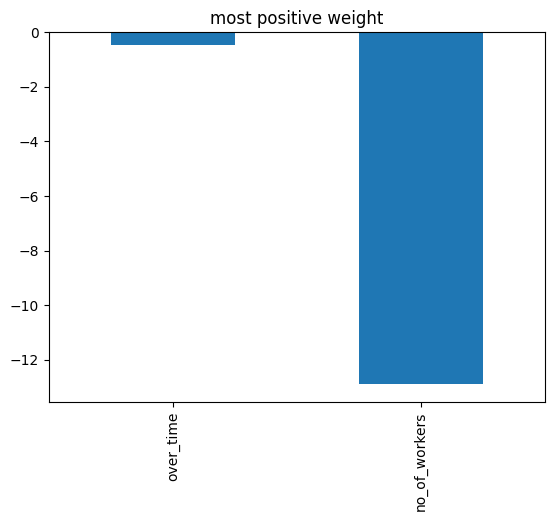

In [294]:
def graph_weights(X_train_,model_, asc, title_):
  # Pesos de los atributos en el modelo
  weights = pd.Series(model_.coef_[0],
                    index=X_train_.columns.values)
  print(weights.sort_values(ascending=asc)[:5].plot(kind='bar', title=title_))
graph_weights(X_train,model,False,"most positive weight")

## c. Realizar las predicciones sobre la base de prueba. Calcule la precisión (accuracy) sobre los datos de prueba.

In [295]:
prediction_test = model.predict(X_test) # obtenemos las predicciones usando el modelo entrenado en el paso anterior
print(f"La medida de accuracy del modelo luego del escalado estándar es:", metrics.accuracy_score(y_test,prediction_test))

La medida de accuracy del modelo luego del escalado estándar es: 0.9915254237288136


<Figure size 1100x1100 with 0 Axes>

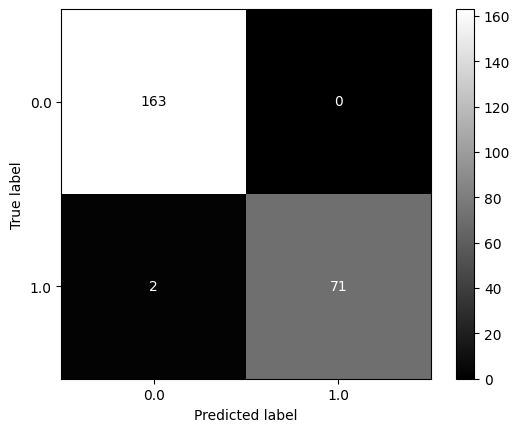

In [296]:
# matriz de confusión, muestras las concidencias y discrepancias entre las prediccioens y los valores reales
def generate_confusion_matrix(y_test_, prediction_test_):
  fig = plt.figure(figsize=(11,11))
  cm = confusion_matrix(y_test_, prediction_test_, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
  disp.plot(cmap='gray')
  plt.show()

generate_confusion_matrix(y_test, prediction_test)

In [297]:
def logistic_report(y_test_,prediction_test_):
  # métricas en general
  print("Accuracy: ", accuracy_score(y_test_,prediction_test_))
  print("\nClassification Report:\n", classification_report(y_test_,prediction_test_))

logistic_report(y_test,prediction_test)

Accuracy:  0.9915254237288136

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       163
         1.0       1.00      0.97      0.99        73

    accuracy                           0.99       236
   macro avg       0.99      0.99      0.99       236
weighted avg       0.99      0.99      0.99       236



# Acción 3: Aplicación K-NN.

## a. Con la base de entrenamiento, aplicar un modelo KNN de aprendizaje automático que pueda aprender del número de trabajadores de cada equipo y el tiempo extra en minutos, para predecir “nivel_productividad”.

In [298]:
df_knn = df.copy()
df_knn=add_nivel_productividad(df_knn) # agregamos nivel_productividad
df_knn=generate_coded_column("nivel_productividad", df_knn) # codificamos nivel_productividad
df_knn_standard = generate_standard_scaled(df_knn.copy(), "nivel_productividad")
df_knn_standard.sample(5)

,no_of_workers,over_time,nivel_productividad
281,0.762180,-0.846382,0
1032,-1.649995,-0.371537,1
1082,0.762180,0.687732,0
344,0.159137,-0.846382,0
338,0.762180,1.701344,0


In [299]:
X_train, X_test, y_train, y_test = split_data('nivel_productividad', df_knn_standard)
class Knn_data: # clase para guardar valores asociados al modelo knn
  def __init__(self,accuracy, knn, y_pred):
    self.accuracy = accuracy
    self.knn = knn
    self.y_pred = y_pred

# función para usar el algoritmo knn usando el número de vecinos que se le pasn como parámetro
def knn_generate(neighbors, X_train_, X_test_, y_train_, y_test_):
  knn = KNeighborsClassifier(n_neighbors=neighbors)
  knn.fit(X_train_, y_train_)
  y_pred = knn.predict(X_test_)
  accuracy = accuracy_score(y_test_, y_pred)
  return Knn_data(accuracy, knn, y_pred)

def obtain_best_knn_accuracy(X_train_, X_test_, y_train_, y_test_):
  knn_final_= Knn_data(0,None,None)
  # probar con números de vecinos desde 1 hasta 20
  for i in range(1,21):
    knn_temp = knn_generate(i, X_train_, X_test_, y_train_, y_test_)
    # si el accuracy con el número actual de vecinos ofrece un modelo mejor lo guardamos en knn_final
    if(knn_temp.accuracy>knn_final_.accuracy):
      knn_final_ = knn_temp
  return knn_final_

knn_final_standard = obtain_best_knn_accuracy(X_train, X_test, y_train, y_test)

<Figure size 1100x1100 with 0 Axes>

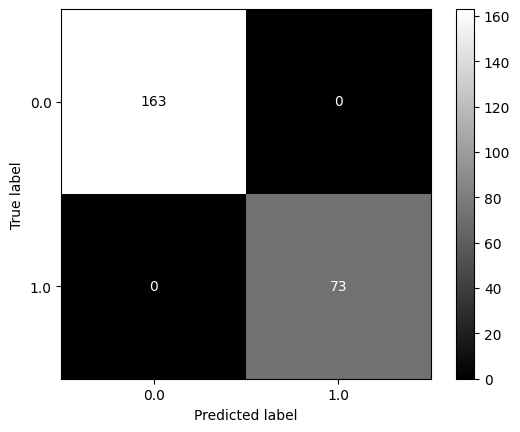

In [300]:
generate_confusion_matrix(y_test, knn_final_standard.y_pred)

## b. Realizar las predicciones sobre la base de prueba. Calcule la precisión (accuracy) sobre los datos de prueba.

In [301]:
print(f"El accuracy más alto obtenido fue: {knn_final_standard.accuracy}")

El accuracy más alto obtenido fue: 1.0


In [302]:
report = classification_report(y_test, knn_final_standard.y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision  recall  f1-score  support
0                   1.0     1.0       1.0    163.0
1                   1.0     1.0       1.0     73.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    236.0
weighted avg        1.0     1.0       1.0    236.0


# Acción 4: Aplicación Árboles de decisión (CART).

## a. Con la base de entrenamiento, aplicar un modelo de árboles de decisión para distinguir “nivel_productividad” bajo y alto usando todas las características.

In [303]:
df_cart=df_original.copy()
df_cart=add_nivel_productividad(df_cart)
df_cart= generate_coded_column('nivel_productividad',df_cart)
df_cart.sample(5)

,date,day,quarter,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,nivel_productividad
355,20,4,2,1,9,0.80,3.94,0.0,2400,0,0.0,0,0,32,0
32,2,7,0,0,10,0.75,19.31,610.0,6480,56,0.0,0,0,29,0
292,16,7,2,0,10,0.65,22.52,1163.0,9720,35,0.0,0,0,24,1
585,33,3,0,0,7,0.70,24.26,1639.0,6720,0,0.0,0,0,26,1
494,27,4,3,1,7,0.60,3.94,0.0,960,0,0.0,0,0,20,1


In [304]:
class correlation:
  def __init__(self, col1, col2, corr):
    self.col1=col1
    self.col2=col2
    self.corr=corr

def generate_corrs_variable(correlation_matrix_, dependant):
  corrs=[]
  cols = list(correlation_matrix_.columns)
  for i in range(0,len(cols)-1):
    if cols[i]!=dependant:
      corrs.append(correlation(dependant,cols[i],correlation_matrix_[dependant][cols[i]]))
  return corrs

def get_top(corrs_, reverse_, top_, dependant):
  corrs_=sorted(corrs_, key=lambda obj: obj.corr, reverse=reverse_)
  print(f"TOP 5 MOST {'POSITIVE' if reverse_ else 'NEGATIVE'} CORRELATED with {dependant}")
  for i in range(top_):
    print(f"{i+1}) {corrs_[i].col1} and {corrs_[i].col2}: {round(corrs_[i].corr,3)}")

corrs=generate_corrs_variable(df_cart.corr(), 'nivel_productividad')
#correlation_matrix
get_top(corrs, True, 5, 'nivel_productividad')

TOP 5 MOST POSITIVE CORRELATED with nivel_productividad
1) nivel_productividad and idle_men: 0.157
2) nivel_productividad and no_of_style_change: 0.135
3) nivel_productividad and idle_time: 0.086
4) nivel_productividad and team: 0.085
5) nivel_productividad and department: 0.083


In [305]:
#correlation_matrix
get_top(corrs, False, 5,  'nivel_productividad')

TOP 5 MOST NEGATIVE CORRELATED with nivel_productividad
1) nivel_productividad and no_of_workers: -0.849
2) nivel_productividad and incentive: -0.378
3) nivel_productividad and targeted_productivity: -0.362
4) nivel_productividad and wip: -0.119
5) nivel_productividad and over_time: -0.061


In [306]:
df_cart=generate_standard_scaled(df_cart,"nivel_productividad")
df_cart.sample(5)

,date,day,quarter,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,nivel_productividad
1108,1.586085,-1.333652,-0.339733,-0.854056,0.745239,0.20902,0.336377,1.156248,0.322467,0.649908,-0.057985,-0.114022,-0.355135,0.159137,0
506,-0.287979,0.703198,2.121416,1.170883,-1.571751,0.20902,-1.018120,-1.019391,-1.029014,-0.847073,-0.057985,-0.114022,-0.355135,0.762180,0
432,-0.485249,-1.333652,1.301033,1.170883,1.614110,-0.30244,-1.005351,-1.019391,-0.901171,-0.847073,-0.057985,-0.114022,-0.355135,-0.845936,1
961,1.092910,0.703198,1.301033,-0.854056,0.455616,0.20902,1.304135,0.371333,-0.006272,1.015837,-0.057985,-0.114022,4.285299,0.159137,0
351,-0.731836,-0.315227,0.480650,1.170883,-0.702879,0.20902,-0.985284,-1.019391,0.432047,-0.847073,-0.057985,-0.114022,-0.355135,0.762180,0


In [307]:
X_train, X_test, y_train, y_test = split_data('nivel_productividad',df_cart)
modelo = DecisionTreeClassifier(
            max_depth         = 4,
            criterion         = 'gini',
            random_state      = 42
          )

# Entrenamiento del modelo
modelo.fit(X_train, y_train)

# Obtener las importancias de las características
importancias = modelo.feature_importances_

# Crear un DataFrame para visualizar mejor las importancias de cada variable
importancias_df = pd.DataFrame({'caracteristica': X_train.columns, 'importancia': importancias})

# Ordenar el DataFrame por importancia de manera descendente
importancias_df.sort_values(by='importancia', ascending=False, inplace=True)

print(importancias_df)


           caracteristica  importancia
13          no_of_workers     0.995011
2                 quarter     0.003331
9               incentive     0.001388
12     no_of_style_change     0.000270
0                    date     0.000000
1                     day     0.000000
3              department     0.000000
4                    team     0.000000
5   targeted_productivity     0.000000
6                     smv     0.000000
7                     wip     0.000000
8               over_time     0.000000
10              idle_time     0.000000
11               idle_men     0.000000


## b. Usando la función graphviz() visualizar el diagrama de árbol.

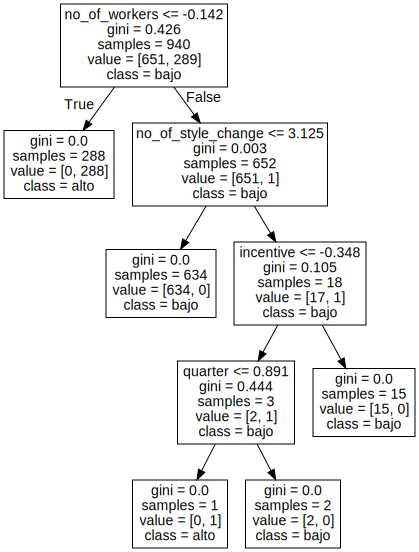

In [308]:
export_graphviz(modelo, out_file="tree.dot", feature_names=X_train.columns, class_names=["bajo","alto"])
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## c. Realizar las predicciones sobre la base de prueba. Calcule la precisión (accuracy) sobre los datos de prueba.

In [309]:
y_pred = modelo.predict(X_test)
print(f"el accuracy score del algoritmo CART es: {metrics.accuracy_score(y_test,y_pred)}")

el accuracy score del algoritmo CART es: 1.0


<Figure size 1100x1100 with 0 Axes>

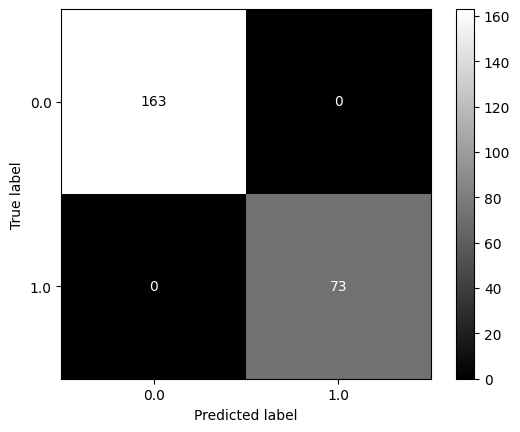

In [310]:
generate_confusion_matrix(y_test, y_pred)

# Conclusiones

## Conlusiones transformación y limpieza de datos
<ul>
<li>Al realizar un análisis inicial de los datos, se identificó un error en la columna 'department', donde se encontraron dos variantes del mismo valor: 'finishing' y 'finishing ' (con un espacio adicional). Para garantizar la consistencia de los datos y facilitar análisis posteriores, se aplicó una función de reemplazo para unificar ambos valores bajo la denominación correcta 'finishing'.</li>
<li>En el análisis de los datos, se identificó que la columna 'date' contiene fechas. Para facilitar la integración de este campo en los modelos predictivos, se transformaron los valores de esta columna al número de días transcurridos desde el 1 de enero de 2015, que representa la fecha más temprana registrada en la columna.</li>
</ul>


## Conclusiones modelo lineal
<ul>
<li>El modelo lineal proporciona un R^2 de 0.844, lo que sugiere que aproximadamente el 86% de la variabilidad en la productividad actual (actual_productivity) puede ser explicada por el modelo.  </li>
<li>El intercepto del modelo es 0.7337984376210129, lo que sugiere que el valor esperado de actual_productivity es aproximadamente 0.734 cuando todas las variables independientes son cero.</li>
<li>Los coeficientes de las variables no_of_workers y over_time son 0.16135178 y -0.01287038 respectivamente, lo que indica que, manteniendo todo lo demás constante, un aumento de una unidad en no_of_workers está asociado con un aumento de 0.16135178 unidades en actual_productivity, y un aumento de una unidad en over_time está asociado con una disminución de 0.01287038 unidades en actual_productivity.</li>
<li>La fuerte correlación de 0.92 entre no_of_workers y actual_productivity contribuye significativamente al alto R^2 del modelo, reflejando la importancia de no_of_workers en la predicción de la productividad."</li>
</ul>


## Conclusiones modelo logístico
<ul>
<li>para el modelo logístico, obtuvimos el peso de las variable en el modelo final, esto nos permite sacar las siguientes conclusiones:
<ul>
<li>Las variables smv, department e idle_men mostraron coeficientes positivos, implicando que incrementos en estas variables están asociados con un aumento en la probabilidad de que la variable dependiente sea clasificada como '1'.</li>
<li>las variables no_of_workers e incentive, con coeficientes negativos, sugieren que aumentos en estos valores disminuyen la probabilidad de obtener '1' como resultado.</li>
</ul>
<li>En el modelo logístico aplicando un escalado estándar, se alcanzó una precisión general (accuracy) del 0.99, clasificando correctamente 234 de los 236 casos. </li>
</li>
<li>Basándonos en el informe de clasificación del modelo logístico, podemos concluir lo siguiente:
<ul>
<li>La precisión para la etiqueta 0 (BAJO) es del 0.99, lo que refleja que, de 165 predicciones de la clase BAJO, 163 fueron correctas.</li>
<li>La precisión para la etiqueta 1 (ALTO) es perfecta, con un valor de 1.00, ya que todas las 71 predicciones de la clase ALTO fueron correctas.</li>
<li>El recall para la etiqueta 0 (BAJO) es de 1.00, indicando que todas las instancias reales de la clase BAJO fueron predichas correctamente.</li>
<li>El recall para la etiqueta 1 (ALTO) es del 0.99, lo cual significa que de las 73 instancias reales de la clase ALTO, 71 fueron predichas correctamente.</li>
<li>El F1-Score para ambas clases fue del 0.99, lo que demuestra un excelente equilibrio entre precisión y recall, evidenciando que el modelo es efectivo para identificar ambas clases.</li>
</ul>
</li>
</ul>


## Conclusiones modelo knn
<ul>
<li>Para el modelo KNN, se evaluó el rendimiento variando el número de vecinos desde 1 hasta 20, utilizando tanto el escalado StandardScaler, obteniendo un accuracy de 1.</li>
<li>
el output de classification_report sobre los resultados del modelo KNN muestra lo siguiente:
<ul>
<li>tanto el recall como el f1 y el precisión tienen un valor de 1, como es lógico porque el modelo obtuvo un accuracy perfecto.</li>
<li>el support refleja que en los datos de testing hay 163 con etiqueta 0 y 73 con etiqueta 1, esto refleja que la muestra mantuvo la propoción entre 0's y 1's del conjunto original (aproximadamente 2.23 con 814 con valor 'bajo' y 368 de valor 'alto'), esto gracias a usar el stratify.</li>
</ul>
</ul>


## Conclusiones modelo CART
<ul>
<li>
El análisis de  la importancia de las características utilizadas por el modelo de árbol de decisión CART para realizar la clasificación muestra que la característica no_of_workers tiene una importancia abrumadoramente alta de aproximadamente 0.995 o 99.5% del total. Esto indica que no_of_workers es, con mucho, el factor más significativo en el modelo al decidir la clasificación de nivel_productividad. Todas las demás variables tienen importancias mucho menores, siendo quarter, incentive y no_of_style_change las únicas otras con importancia diferente de cero, pero sus valores son relativamente pequeños (0.333%, 0.138% y 0.027% respectivamente).

</li>
<li>
no_of_workers se identificó como la variable más influyente, por lo cual fue seleccionada como primer nodo del árbol debido a su bajo índice de Gini de 0.426. Este resultado sugiere que no_of_workers tiene una capacidad significativa para segmentar las clases de manera efectiva. Sorprendentemente, se logró una precisión perfecta de 1 utilizando una profundidad máxima de solo 1 en el árbol, lo que indica que no_of_workers por sí sola es suficiente para clasificar con exactitud los niveles de productividad.
</li>
<li>
El árbol de decisión CART, ilustrado en el gráfico, requiere una profundidad de cuatro niveles para alcanzar nodos completamente puros. La división inicial basada en no_of_workers resulta en una separación casi perfecta de las clases. De este análisis, se desprenden las siguientes observaciones específicas:
<ul>
<li>Una división en no_of_workers <= -0.142 lleva directamente a un nodo que clasifica exclusivamente como 'ALTO'.
</li>
<li>Cuando no_of_workers es mayor a -0.142, se necesitan condiciones adicionales para alcanzar la pureza del nodo. Específicamente, si no_of_style_change excede 3.125, combinado con incentive <= -0.348 y quarter <= 0.891, se logra un nodo puramente 'ALTO'.</li>
<li>el resto de los nodos finales son nodos puros de valores BAJO</li>
</ul>
</li>
</ul>

# BIBLIOGRAFÍA

<ul>
<li>Kane, F. (2017). Hands-On Data Science and Python Machine Learning. Packt Publishing.</li>
<li>Raschka, S., & Mirjalili, V. (2017). Python Machine Learning - Second Edition: Vol. 2nd ed. Packt Publishing.</li>
<li> Ozdemir, S. (2016). Principles of data science. Packt Publishing Ltd. </li>
</ul>
